## Importing

### Importing Libraries

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.axes import Axes

# To ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# for pre-processing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# For Feature Selection
from sklearn.feature_selection import SelectKBest, f_regression

# To split the data
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# To evaluate the models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Importing Data

In [2]:
# Reading the csv file
df = pd.read_csv('student-por.csv')

# Creating a copy of the DataFrame
data = df.copy()

###
# .copy() will create a true copy
# data = df will just make data refer to df
###

## 1. Understanding the Data

In [3]:
# Checking the top 5 rows
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [4]:
# Checking the minmum and maximum age so we can understand the spread
print('min age of student:', min(data['age']))
print('max age of student:',max(data['age']))

min age of student: 15
max age of student: 22


In [5]:
# Checking the shape i.e number of rows & columns
data.shape

(649, 33)

In [6]:
data['absences'].unique()

array([ 4,  2,  6,  0, 10,  8, 16, 14,  1, 12, 24, 22, 32, 30, 21, 15,  9,
       18, 26,  7, 11,  5, 13,  3], dtype=int64)

In [7]:
# Checking the average scores
print('mean of G1:', data['G1'].mean())
print('mean of G2:', data['G2'].mean())

### NOTE: G3 is the final year grade (issued at the 3rd period),
###       while G1 and G2 correspond to the 1st and 2nd period grades.
###       G3 is strongly correlated with G1 and G2
print('mean of G3:', data['G3'].mean())

mean of G1: 11.399075500770415
mean of G2: 11.570107858243452
mean of G3: 11.906009244992296


In [8]:
table = data.groupby('traveltime')['G3'].mean()
table

traveltime
1    12.251366
2    11.577465
3    11.166667
4    10.875000
Name: G3, dtype: float64

## 2. Data Preparation

### 2.1 Data Cleaning

In [9]:
data.isnull().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

In [10]:
# Checking for duplicate data
data.duplicated().sum()

0

In [11]:
# CHecking the number of unique values in each column
data.nunique()

school         2
sex            2
age            8
address        2
famsize        2
Pstatus        2
Medu           5
Fedu           5
Mjob           5
Fjob           5
reason         4
guardian       3
traveltime     4
studytime      4
failures       4
schoolsup      2
famsup         2
paid           2
activities     2
nursery        2
higher         2
internet       2
romantic       2
famrel         5
freetime       5
goout          5
Dalc           5
Walc           5
health         5
absences      24
G1            17
G2            16
G3            17
dtype: int64

In [12]:
# Information about the data types and the no. of entries in the columns
data['school'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 649 entries, 0 to 648
Series name: school
Non-Null Count  Dtype 
--------------  ----- 
649 non-null    object
dtypes: object(1)
memory usage: 5.2+ KB


### 2.2 Categorizing Features

Categorical features

In [13]:
# Getting Categorical Features
categorical_features = data.select_dtypes(include=['object']).columns

# Getting Nominal Features
categorical_features_nominal = ['Mjob', 'Fjob', 'reason', 'guardian']

# Ordinal Features - Removing the nominal features from the categorical features
categorical_features_ordinal = list(categorical_features.drop(categorical_features_nominal))

Numerical features

In [14]:
# Getting Numerical Features
numerical_features = list(data.select_dtypes(exclude=['object']).columns)

## 3. Feature Engineering


### 3.1 Final Grades
  COnverting marks into percentage and assigning grades -
  * 16-20 : Excellent
  * 14-15 : Good
  * 12-13 : Satisfactory
  * 10-11  : Poor
  * 0-9   : Fail

In [15]:
data.loc[data['G3'] >= 16, 'final_grade'] = 'Excellent' # above 18
data.loc[data['G3'].between(13,16), 'final_grade'] = 'Good' # 15-17
data.loc[data['G3'].between(11,14), 'final_grade'] = 'Satisfactory' # 11-14
data.loc[data['G3'].between(9,12), 'final_grade'] = 'Poor' # 6-10
data.loc[data['G3'] <= 9, 'final_grade'] = 'Fail' # below 6

## Plotting function

In [16]:
def multiplot(x: list, y: str, data: pd.DataFrame, plot_type: str, palette= None, grid=False, dpi=100) -> Axes:

  # Checking the DataTypes of the arguments
  if not isinstance(x, list):
    raise TypeError('Input must be a list. Ensure it\'s a list of feature column names.')

  if not isinstance(y, str):
    raise TypeError('Input must be a string')

  if not isinstance(data, pd.DataFrame):
    raise TypeError('Input must be a DataFrame')

  if not isinstance(plot_type, str):
    raise TypeError('Input must be a string')

  if palette is None:
    palette = sns.color_palette('muted')

  if not isinstance(grid, bool):
    raise TypeError('Input must be a boolean')

  if not isinstance(dpi, int):
    raise TypeError('Input must be an integer')


  # Settings
  sns.set_style('white')
  if grid is True:
    sns.set_style('whitegrid')


  if dpi is None:
    dpi = 100

  # creating the plot function from input
  plot_func = getattr(sns, plot_type, None)

  if plot_func is None or not callable(plot_func):
    raise ValueError(f'Invalid plot type: {plot_type}. Ensure it\'s a valid Seaborn plot type.')

  # Getting the number of features
  length = int(len(x))

  # Calculating the size of the plot
  rows = int(np.ceil(length/3)) # Such that we have 3 plot in each row

  # Dynamically adjusting the figure size
  figsize = (3 * 4.7, rows * 4.7)

  #creating the plot
  f, axs = plt.subplots(rows, 3, figsize=figsize, dpi=dpi)

  # Flatten axs for easier indexing if there is only one row or column
  axs = axs.flatten()

  # iterating through subplots
  for count, ax in enumerate(axs):
    if count < length:
      # Getting the feature to plot
      feature = x[count]

      # Plotting
      plot_func(x=data[feature], y=data[y], palette=palette, ax=ax)
      ax.set_title(f'{y} by {feature}')

    else:
      # Deleting unused subplots
      ax.axis('off')

  # Adding title and finishing touches
  plt.suptitle('Bivariate Data Analysis', fontsize=16)
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

  return f

## 4. EDA - Exploratory Data Analysis

In [17]:
# Setting a color palette for Visuals
color_palette = sns.color_palette('muted')

### Documented graphs
#### For Inisghts, find the link to the complete documentation in the **README** file.

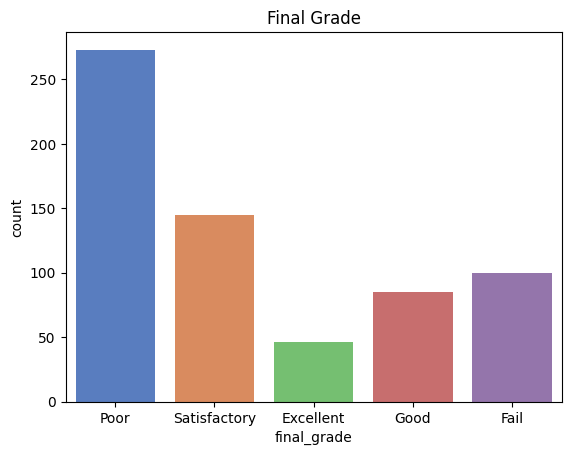

In [18]:
sns.countplot(x=data['final_grade'], palette=color_palette)
plt.title('Final Grade')
plt.savefig('final_grade.png')

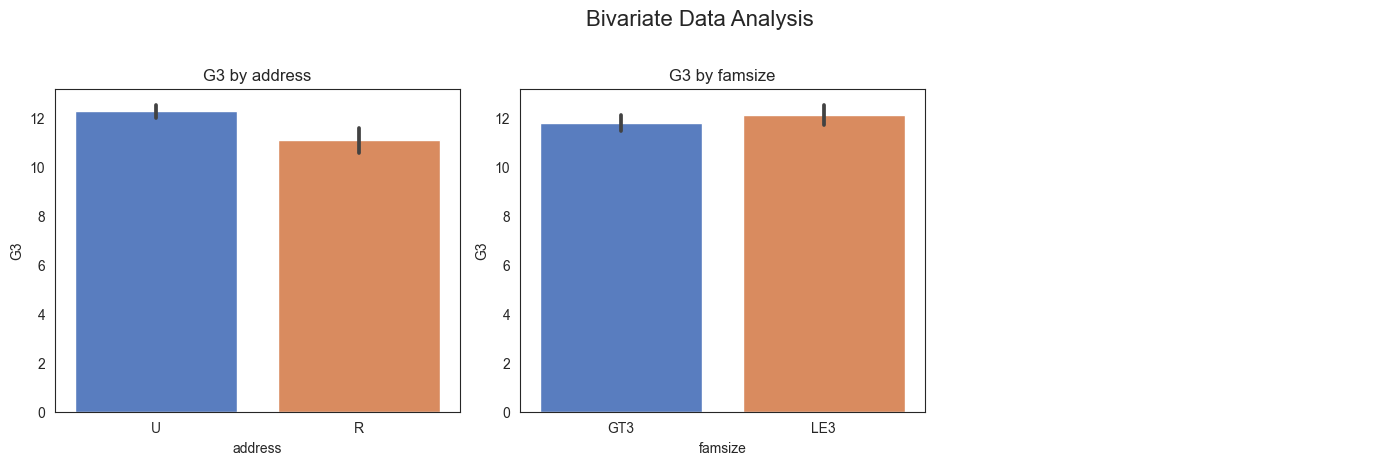

In [19]:
X, Y = ['address', 'famsize'], 'G3'

plot = multiplot(x=X, y=Y ,data=data, plot_type='barplot', palette=color_palette)
plot.savefig('plot1')

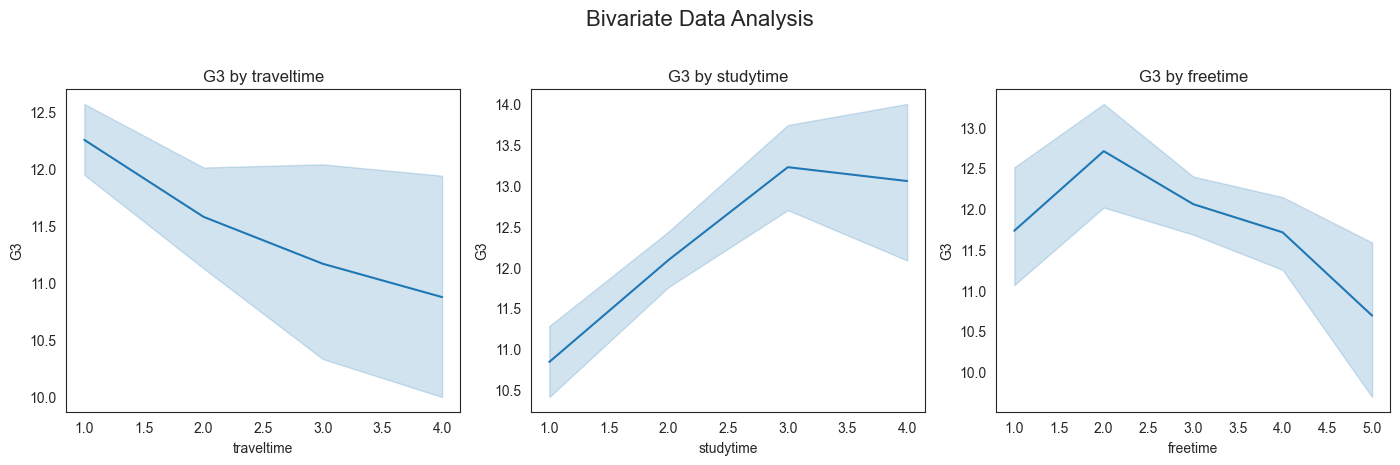

In [20]:
X, Y = ['traveltime', 'studytime', 'freetime'], 'G3'

plot = multiplot(x=X, y=Y ,data=data, plot_type='lineplot', palette=color_palette)
plot.savefig('plot2')

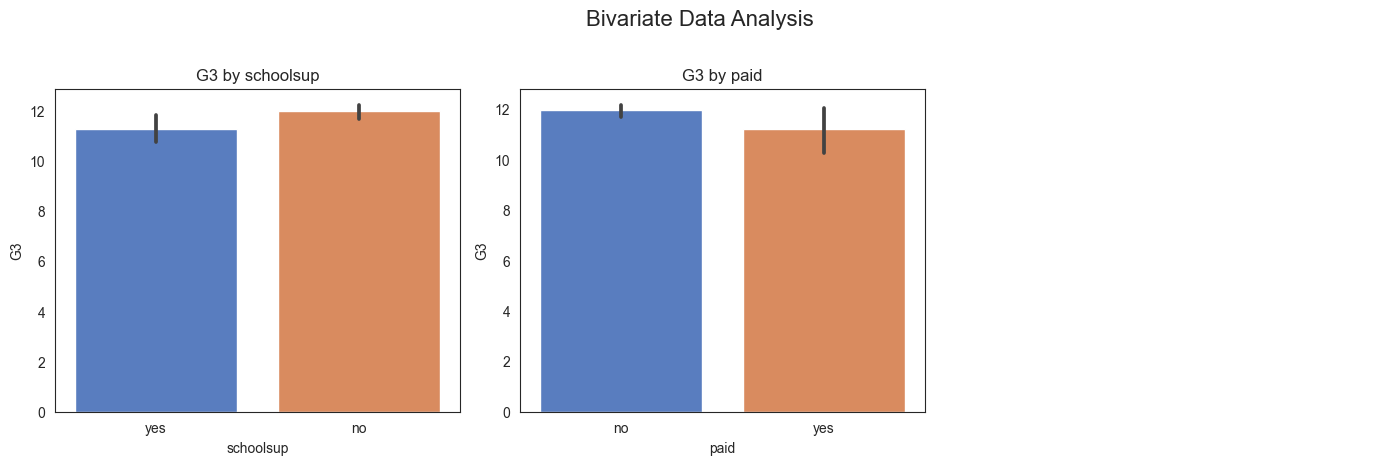

In [21]:
X, Y = ['schoolsup', 'paid'], 'G3'

plot = multiplot(x=X, y=Y ,data=data, plot_type='barplot', palette=color_palette)
plot.savefig('plot3')

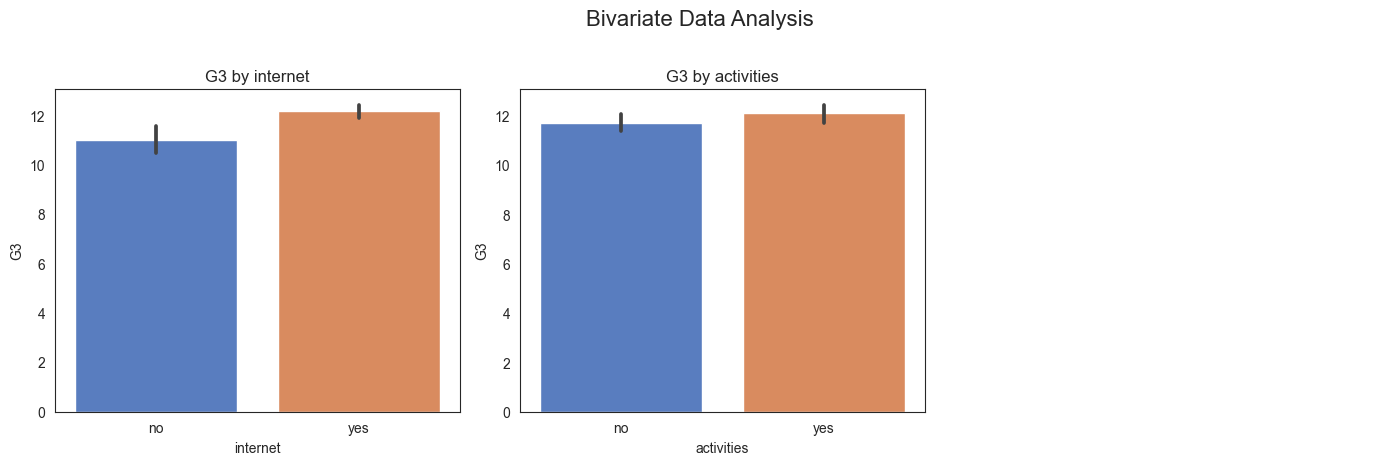

In [22]:
X, Y = ['internet', 'activities'], 'G3'

plot = multiplot(x=X, y=Y ,data=data, plot_type='barplot', palette=color_palette)
plot.savefig('plot4')

In [23]:
data.iloc[:,18]

0       no
1       no
2       no
3      yes
4       no
      ... 
644    yes
645     no
646    yes
647     no
648     no
Name: activities, Length: 649, dtype: object

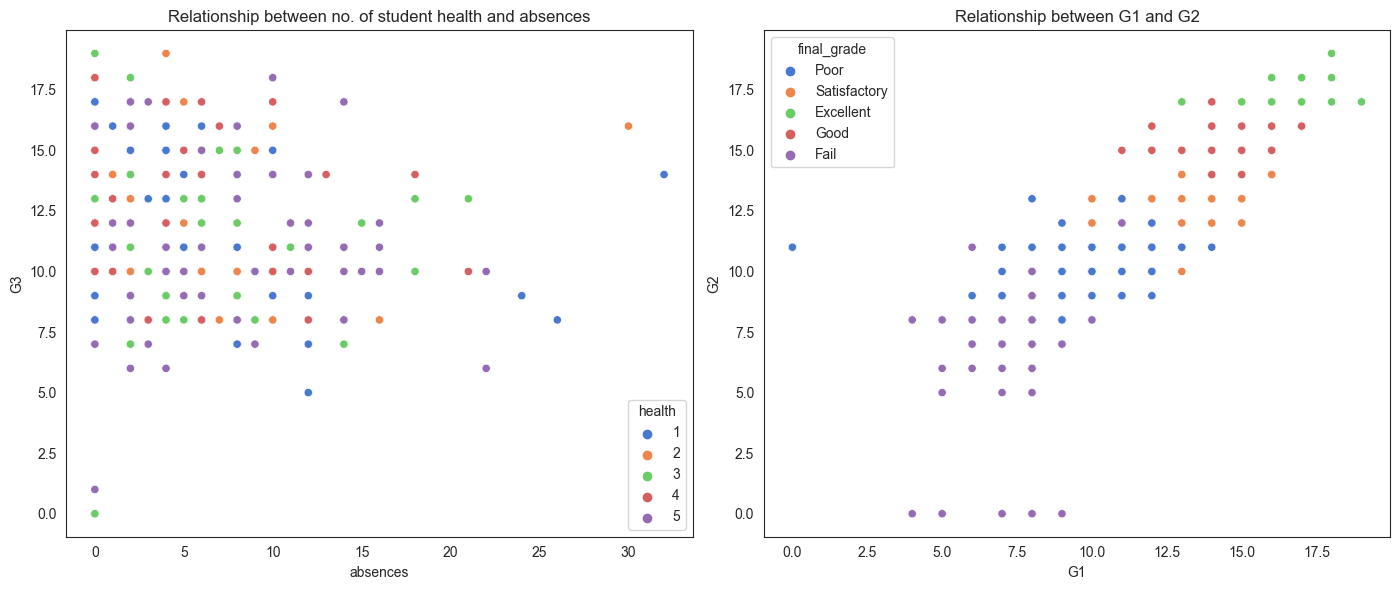

In [24]:
f, axs = plt.subplots(1,2, figsize=(14.1,6))


ax = axs[0]
sns.scatterplot(x=data['absences'], y=data['G3'], hue=data['health'], palette=color_palette, ax=ax)
ax.set_title('Relationship between no. of student health and absences')

ax = axs[1]
sns.scatterplot(x=data['G1'], y=data['G2'], hue=data['final_grade'], palette=color_palette, ax=ax)
ax.set_title('Relationship between G1 and G2')

plt.tight_layout()
plt.savefig('plot5.png')

### 4.1 Univariate Data Analyis

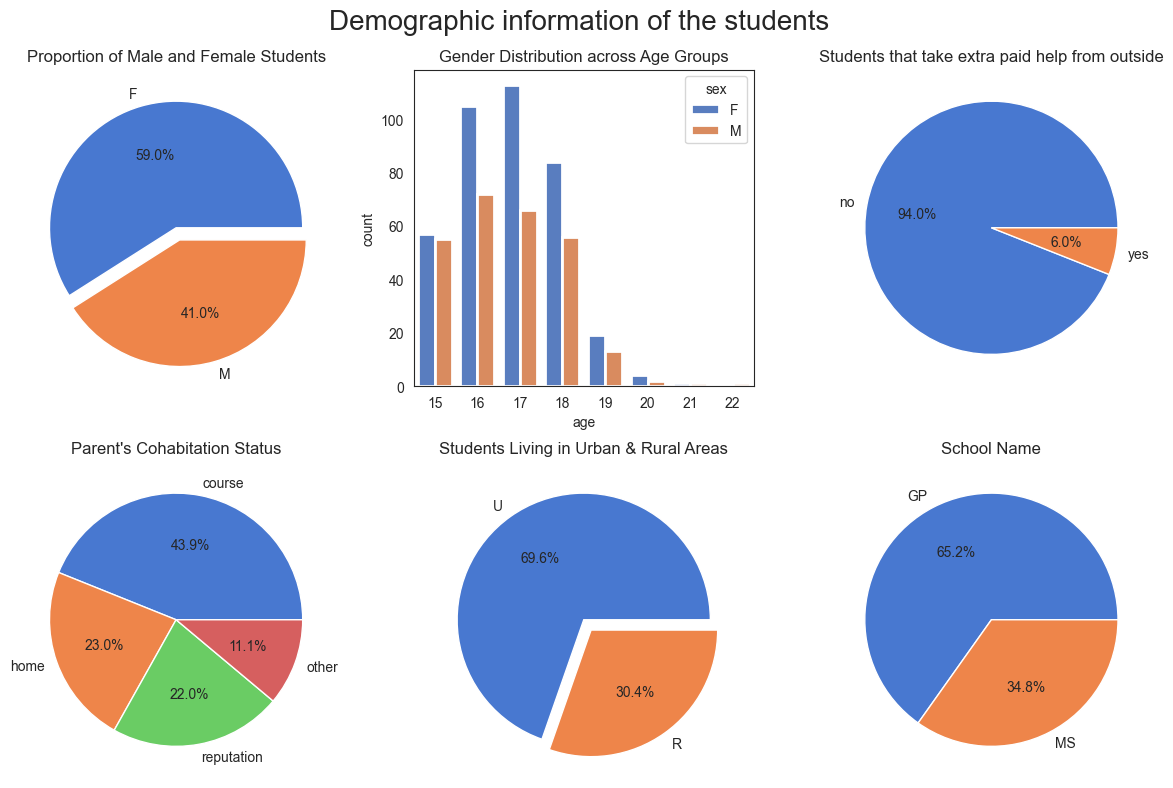

In [25]:
# Creating basic plots about the Demographic information of students

f, axs = plt.subplots(2,3, figsize=(12,8))

ax = axs[0,0]
ax.pie(x=data['sex'].value_counts(), labels = data['sex'].value_counts().index,
       colors = color_palette, autopct='%1.1f%%', explode=(0,0.1))
ax.set_title('Proportion of Male and Female Students')

ax = axs[0,1]
sns.countplot(x=data['age'], hue=data['sex'],
              palette = color_palette, linewidth=2, ax=ax)
ax.set_title('Gender Distribution across Age Groups')

ax = axs[0,2]
ax.pie(x=data['paid'].value_counts(),
       labels = data['paid'].value_counts().index,
       colors = color_palette,
       autopct='%1.1f%%')
ax.set_title('Students that take extra paid help from outside')

ax = axs[1,0]
ax.pie(x=data['reason'].value_counts(),
       labels = data['reason'].value_counts().index,
       colors = color_palette,
       autopct='%1.1f%%')
ax.set_title('Parent\'s Cohabitation Status')

ax = axs[1,1]
ax.pie(x=data['address'].value_counts(),
       labels=data['address'].value_counts().index,
       colors = color_palette, autopct= '%1.1f%%',
       explode = (0,0.1))
ax.set_title('Students Living in Urban & Rural Areas')

ax = axs[1,2]
ax.pie(x=data['school'].value_counts(),
       labels=data['school'].value_counts().index,
       colors = color_palette, autopct= '%1.1f%%')
ax.set_title('School Name')


plt.suptitle('Demographic information of the students', fontsize=20)


#plt.delaxes(ax=axs[1,2])
plt.tight_layout()
plt.show()

### Insights:


*   No. of female students and male students is almost equal, no. of female students is slightly higher.
*   Most no. of students are between the ages 15-18

*   Most of the students are from Gabriel Pereira School.

*   Almost 50% of the students take extra paid classes outside of school.
*   The reason majority of the students joined is due to the course.
  * Distance from home and school reputation.


*   78% of the students come from Urban areas and 22% from Rural areas.







### 4.2 Bivariate Data Analysis

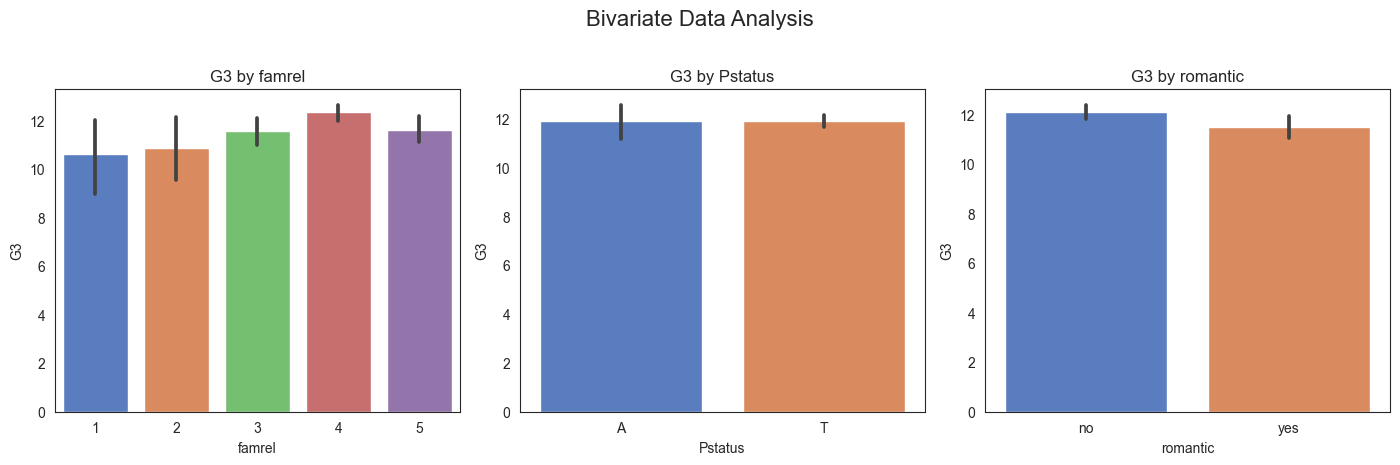

In [26]:
# Creating more graphs that are related to the student's academics

graphs_list = ['famrel', 'Pstatus', 'romantic']

fig = multiplot( x=graphs_list, y='G3', data=data, plot_type='barplot', palette=color_palette)
fig.savefig('Extra graphs')

Insights:


*   Family of 3 or less show better family relationship.

*   Students with Internet availability show higher marks


*   Students taking extra paid classes show higher marks.

*   Students who study for 5-10 hours a week show higher average marks.

*   Optimal free time after school is 2.
    * 1 - very low; 5 - very high

* Consumption of alcohol during the week increases the more they go out with friends.

*   Most students scored poorly.




## 5. Data Pre-Processing

### 5.1 Pre-processing

In [27]:
# Creating a backup
data_backup = data.copy()

Label encoder - For Ordinal Data (There is order of significance)\
One Hot Encoder - For Nominal Data (No order of significance)

In [28]:
# Scaling Categorical Ordinal Features

label = LabelEncoder()

# Going through and converting one column at a time
for col in categorical_features_ordinal:
  data[col] = label.fit_transform(data[col])

In [29]:
# Scaling Categorical Nominal Features
one_hot = OneHotEncoder(sparse=False, drop='first')

# Convert the columns
one_hot_encoded = one_hot.fit_transform(data[categorical_features_nominal])

# convert the above into a DataFrame
encoded_df = pd.DataFrame(one_hot_encoded, columns=one_hot.get_feature_names_out(categorical_features_nominal))

# Now add the new df in place of the old ones in the Data
data = pd.concat([data.drop(columns=categorical_features_nominal), encoded_df], axis=1)

In [30]:
# Scaling Numerical Features

scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

In [31]:
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,...,Mjob_teacher,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_home,reason_other,reason_reputation,guardian_mother,guardian_other
0,0,0,1.031695,1,0,0,1.310216,1.540715,0.576718,0.083653,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0,0,0.210137,1,0,1,-1.336039,-1.188832,-0.760032,0.083653,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,-1.432980,1,1,1,-1.336039,-1.188832,-0.760032,0.083653,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0,0,-1.432980,1,0,1,1.310216,-0.278983,-0.760032,1.290114,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0,0,-0.611422,1,0,1,0.428131,0.630866,-0.760032,0.083653,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### 5.2 Feature Selection

In [32]:
# dropping features
data=data.drop(['sex', 'G1', 'G2'], axis=1)

In [33]:
# Independent Variables - Feature table that will be used to predict Y
X = data.drop(columns='G3')
X = data.drop(columns='final_grade')

In [34]:
# Dependent Variable
Y = data['G3']

In [35]:
# Selecting the best Features using SelectKbest and f_regression
feature_selector = SelectKBest(score_func=f_regression, k='all')
X_new = feature_selector.fit_transform(X,Y)

In [36]:
# Saving the new features to variable X
X = X_new

### 5.3 Train Test Split

In [37]:
# Splitting the dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,
                                                    random_state=44)

## 6. Modelling

### 6.1 Initialising the models

In [38]:
# Initialising the models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Support Vector Machine': SVR(),
    'Neural Network': MLPRegressor()
}

### 6.2 Training

In [39]:
# Training the models
for name, model in models.items():
  model.fit(X_train, Y_train)

## 7. Model Evaluation

### 7.1 Calculating metrics

In [40]:
# Evaluating the models
results = {}
overfit = {}

for name, model in models.items():
  Y_pred = model.predict(X_test)

  mae = mean_absolute_error(Y_test, Y_pred)
  mse = mean_squared_error(Y_test, Y_pred)
  rmse = mean_squared_error(Y_test, Y_pred, squared=False)
  r2 = r2_score(Y_test, Y_pred)

  # Storing results
  results[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'r2': r2}



  ### Calculating Overfitting ####

  # Predicting on training data and testing data (Seen and Unseen data)
  training_preds = model.predict(X_train)
  testing_preds = model.predict(X_test)

  # Calculating the MSE
  train_MSE = mean_squared_error(Y_train, training_preds)
  test_MSE = mean_squared_error(Y_test, testing_preds)

  # overfitting values
  overfit[name] = {'Training MSE': train_MSE, 'Testing MSE':test_MSE}

#number of metrics
n = len(results[list(models.keys())[0]])

# Printing the results
results_df = pd.DataFrame.from_dict(results).T # .T to transpose it
overfit_df = pd.DataFrame.from_dict(overfit).T

# calucating difference to check overfitting
overfit_df['Difference'] = abs(overfit_df['Training MSE'] - overfit_df['Testing MSE'])

print(results_df)
print(f'\n{overfit_df}')

                                  MAE           MSE          RMSE        r2
Linear Regression        8.008284e-16  9.736305e-31  9.867271e-16  1.000000
Random Forest Regressor  4.622772e-03  9.039389e-04  3.006558e-02  0.998975
Support Vector Machine   1.506775e-01  5.966620e-02  2.442666e-01  0.932332
Neural Network           1.169462e-01  2.454062e-02  1.566545e-01  0.972168

                         Training MSE   Testing MSE    Difference
Linear Regression        9.735311e-31  9.736305e-31  9.937989e-35
Random Forest Regressor  1.575290e-04  9.039389e-04  7.464100e-04
Support Vector Machine   1.748855e-02  5.966620e-02  4.217765e-02
Neural Network           5.958438e-03  2.454062e-02  1.858218e-02


### 7.2 Comparing models

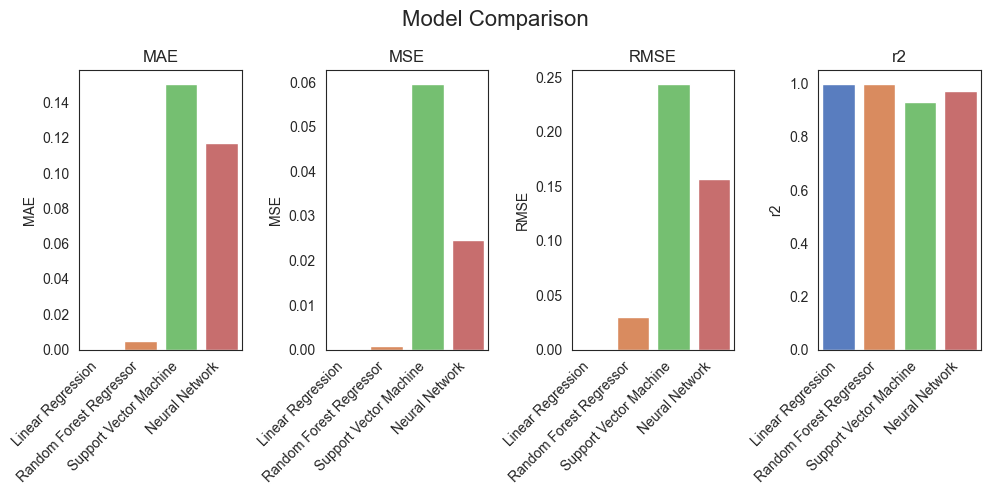

In [41]:
# creating a figure to compare the model metrics
f, axs = plt.subplots(1,n,figsize=(10,5))

for i in range(0,n):
  ax=axs[i]
  metric = results_df.columns[i]
  sns.barplot(x=results_df.index, y = results_df[metric], palette=color_palette, ax=ax)
  ax.set_title(metric)
  ax.set_xticklabels(labels=results_df.index, rotation=45, ha='right')
  ax.set_xlabel('')
  ax.set_ylabel(metric)

plt.suptitle('Model Comparison', fontsize=16)
plt.tight_layout()
plt.savefig('Model_performance')
plt.show()

### 7.3 Overfitting Visualisation

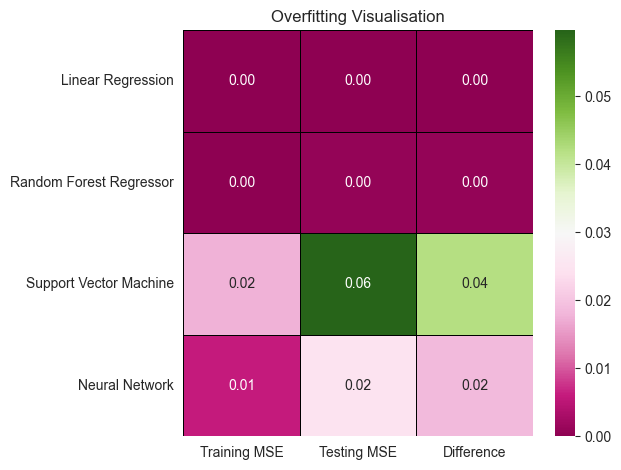

In [42]:
# Creating a heatmap for overfitting values
sns.heatmap(data=overfit_df, cmap="PiYG", linewidth=0.5, linecolor='black', annot=True, fmt='.2f')
plt.title('Overfitting Visualisation')
plt.tight_layout()
plt.savefig('overfitting.png')

We conclude that Linear Regression is the best fit.

**For detailed explanation, see the documentation linked in README file**

## 8. Most significant features

In [43]:
# Intialising our best model
best_model = LinearRegression()
best_model.fit(X,Y)

# getting the coefficients in the model
coefficients = best_model.coef_

# Generating feature_names
feature_names = [(f'feature{i}') for i in range(X.shape[1])]

#Converting to a DataFrame and sorting in descending order
coeff_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})

# Creating a column for absolute values
coeff_df['abs_coeff'] = coeff_df['coefficient'].abs()

# Sorting the coefficients in descending order of the absolute coefficients.
coeff_df = coeff_df.sort_values(by='abs_coeff', ascending=False)

print(coeff_df)

      feature   coefficient     abs_coeff
25  feature25  1.000000e+00  1.000000e+00
9    feature9  9.506786e-16  9.506786e-16
1    feature1 -9.436896e-16  9.436896e-16
0    feature0  8.689700e-16  8.689700e-16
38  feature38  8.495808e-16  8.495808e-16
20  feature20  7.195633e-16  7.195633e-16
30  feature30 -6.277595e-16  6.277595e-16
2    feature2 -4.576585e-16  4.576585e-16
26  feature26  4.408538e-16  4.408538e-16
16  feature16 -3.823416e-16  3.823416e-16
8    feature8  3.261029e-16  3.261029e-16
17  feature17  2.899467e-16  2.899467e-16
19  feature19 -2.766415e-16  2.766415e-16
31  feature31 -2.543051e-16  2.543051e-16
34  feature34 -2.012279e-16  2.012279e-16
33  feature33  1.994932e-16  1.994932e-16
27  feature27  1.942599e-16  1.942599e-16
3    feature3 -1.616128e-16  1.616128e-16
12  feature12 -1.528402e-16  1.528402e-16
22  feature22 -1.458112e-16  1.458112e-16
29  feature29  1.316237e-16  1.316237e-16
21  feature21 -1.099024e-16  1.099024e-16
32  feature32  9.653231e-17  9.653

Getting the top 4 most significant features

In [44]:
# Storing the top 4 feature numbers
sig_feature_numbers = coeff_df.head(4).index

# list to store the actual feature names
sig_feature_names = []

# Getting the actual names from feature numbers
sig_feature_names = [data.iloc[:,j].name for j in sig_feature_numbers]

print(sig_feature_names)

['G3', 'failures', 'age', 'school']


We Ignore 'G3' as its the target variable

## 9. Interpretation


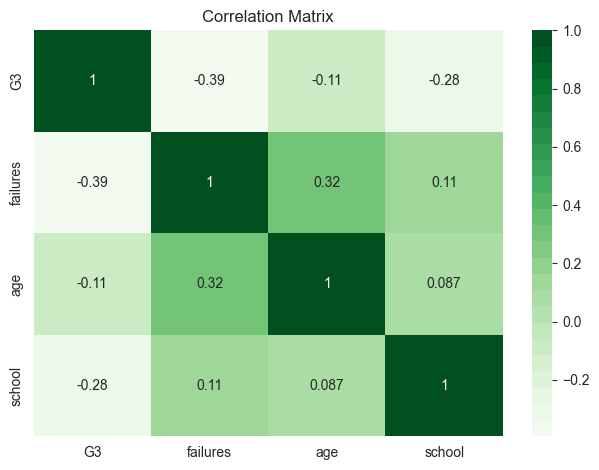

In [45]:
# Creating a table with significant features
signif_table = data[sig_feature_names]

# Heatmap of correlation matrix
corr_matrix = signif_table.corr()
sns.heatmap(corr_matrix, cmap=sns.color_palette("Greens",25), annot=True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()